In [ ]:
# if u want to run on colab, try to zip up the folders in final folder. and upload to colab
!unzip files.zip

Archive:  files.zip
  inflating: data/i000000.jpg        
  inflating: data/i000001.jpg        
  inflating: data/i000002.jpg        
  inflating: data/i000003.jpg        
  inflating: data/i000004.jpg        
  inflating: data/i000005.jpg        
  inflating: data/i000006.jpg        
  inflating: data/i000007.jpg        
  inflating: data/i000008.jpg        
  inflating: data/i000009.jpg        
 extracting: dataset/__init__.py     
  inflating: dataset/InferenceDataset.py  
  inflating: dataset/ReferenceDataset.py  
  inflating: files/desktop.ini       
  inflating: files/Instructions Final Project.pdf  
  inflating: files/Pitch_template.pptx  
  inflating: files/report_group_XX.tex  
  inflating: models/AttnFSRCNN~15_2_8_0.0001.pth  
  inflating: models/Discriminator~20_4_8_D.pth  
  inflating: models/Discriminator~20_4_8_D_BEST.pth  
  inflating: models/FSRCNN~10_2_1_0.001.pth  
  inflating: models/FSRCNN~10_4_32_0.0005.pth  
  inflating: models/FSRCNN~10_4_32_0.0005_BEST.pth  
  i

# Train Models

In [ ]:
import random
import os
import torch
from torch import nn
from torch import optim
from torch.utils.data import DataLoader
from torch.utils.data import SubsetRandomSampler
from torchvision import transforms

import matplotlib.pyplot as plt
from IPython.display import display, clear_output

from dataset.ReferenceDataset import ReferenceDataset
from nets.fsrcnn import FSRCNN
from nets.PaperSR import PaperSR
from nets.AttnFSRCNN  import AttnFSRCNN
from nets.ResFSRCNN import ResFSRCNN
from utils.vis import zoom_and_display_data
from utils.vis import visualize_data, visualize_images

# Transformations
from utils.process.corruption import Corruption

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(torch.cuda.get_device_name(0))

# Hyperparameters
BATCH_SIZE = 32
EPOCHS = 20
SCALE_FACTOR = 4  # Factor by which images are downscaled

torch.manual_seed(0)

NVIDIA A100-SXM4-40GB


## Get Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Transform
transform = transforms.Compose([Corruption(), transforms.ToTensor(),])

# Create datasets
pathToData = "/content/drive/MyDrive/filtered"
dataset = ReferenceDataset(pathToData, transform=transform, scale_factor=SCALE_FACTOR)

# Create dataloaders

testAndValProportion = 0.1
portion = 0.5
partition1 = int(len(dataset) * testAndValProportion)
partition2 = int(len(dataset) * 2 * testAndValProportion)
end = int(len(dataset)*portion)
partition1 = int(partition1*portion)
partition2 = int(partition2*portion)
print(partition1)
print(partition2)
print(end)
# Create dataloaders
indicies = list(range(len(dataset)))
random.shuffle(indicies)

test_loader = DataLoader(dataset, batch_size=BATCH_SIZE, sampler=SubsetRandomSampler(indicies[:partition1]))
val_loader = DataLoader(dataset, batch_size=BATCH_SIZE, sampler=SubsetRandomSampler(indicies[partition1:partition2]))
train_loader = DataLoader(dataset, batch_size=BATCH_SIZE, sampler=SubsetRandomSampler(indicies[partition2:]))

print(f"Number of batches: {len(train_loader)}")

551
1102
5512
Number of batches: 311


## Visualize Train Data

In [ ]:
randomize_idx = True  # Set to False to disable randomization
random_index = random.randint(0, len(dataset) - 1) if randomize_idx else 0

low_res, high_res = dataset[random_index]
print(low_res.shape, high_res.shape)

torch.Size([3, 200, 200]) torch.Size([3, 800, 800])


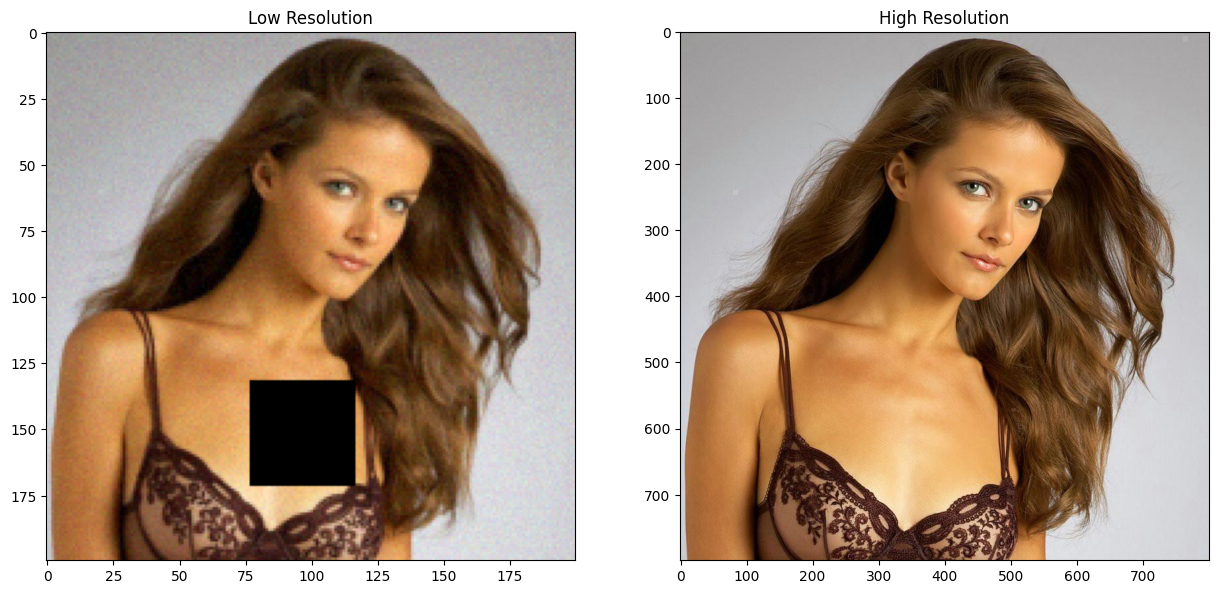

8470


In [ ]:
visualize_data(low_res, high_res)
print(random_index)

### Zooming in on the data

In [ ]:
# Calculate scale factors
scale_factor_x = high_res.shape[-1] / low_res.shape[-1]
scale_factor_y = high_res.shape[-2] / low_res.shape[-2]
print(scale_factor_x)
print(scale_factor_y)
assert scale_factor_x == scale_factor_y, "Scale factors are not equal"

print(f'Scale Factor: {SCALE_FACTOR}')

4.0
4.0
Scale Factor: 4


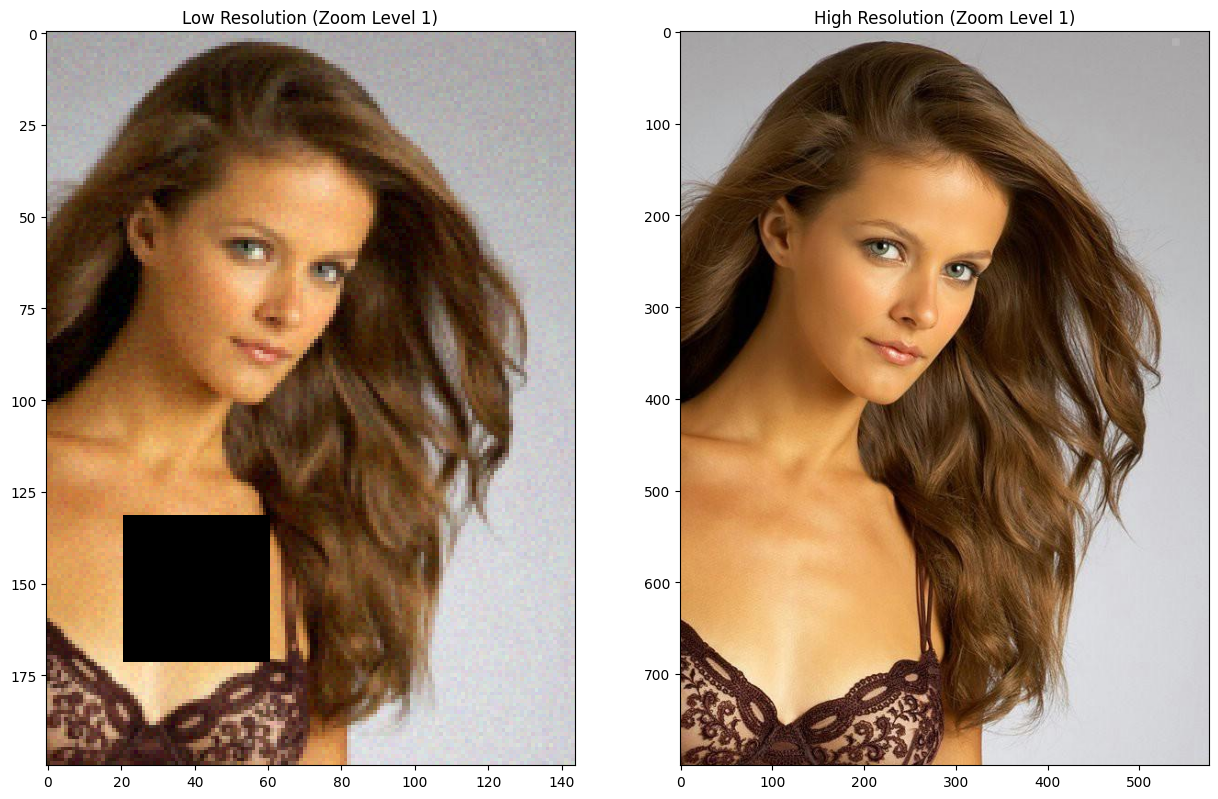

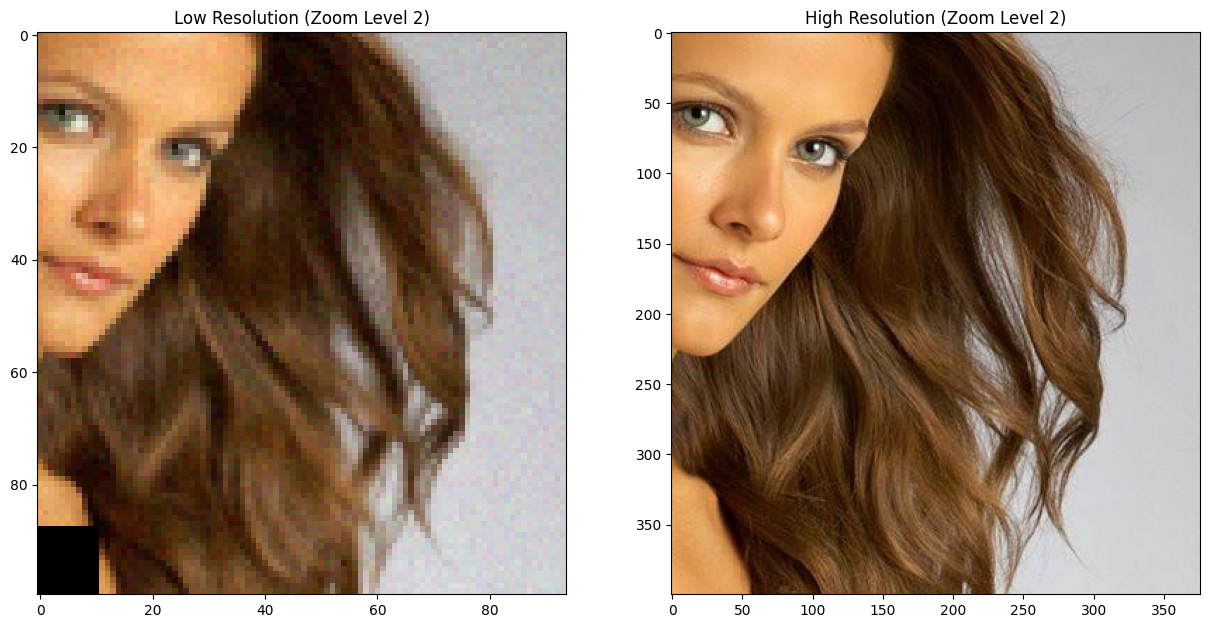

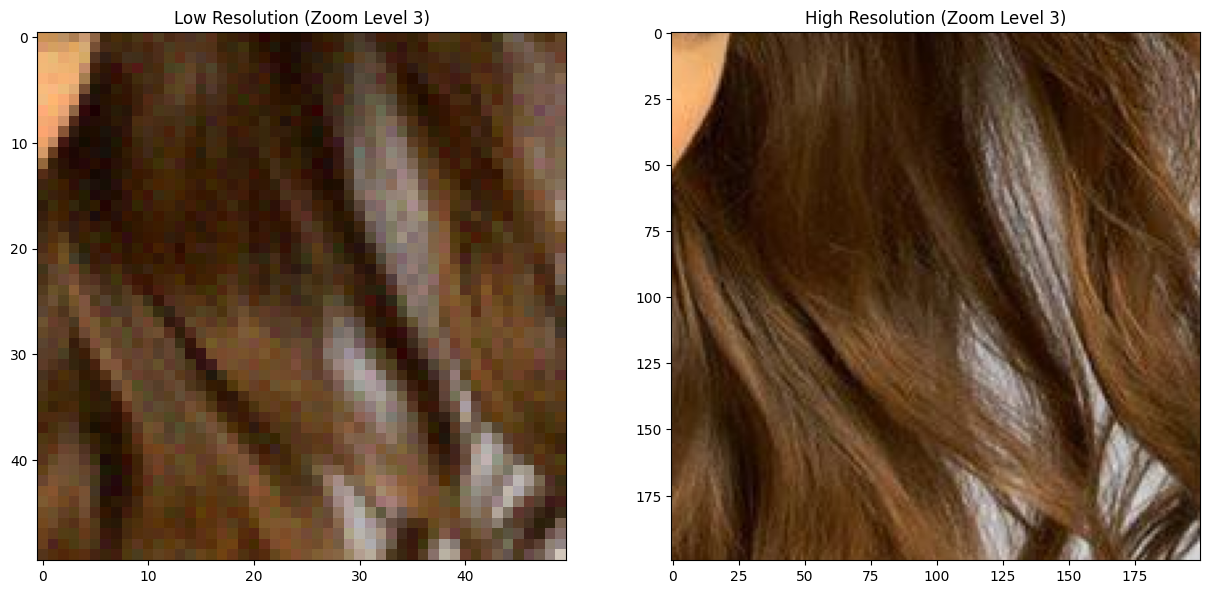

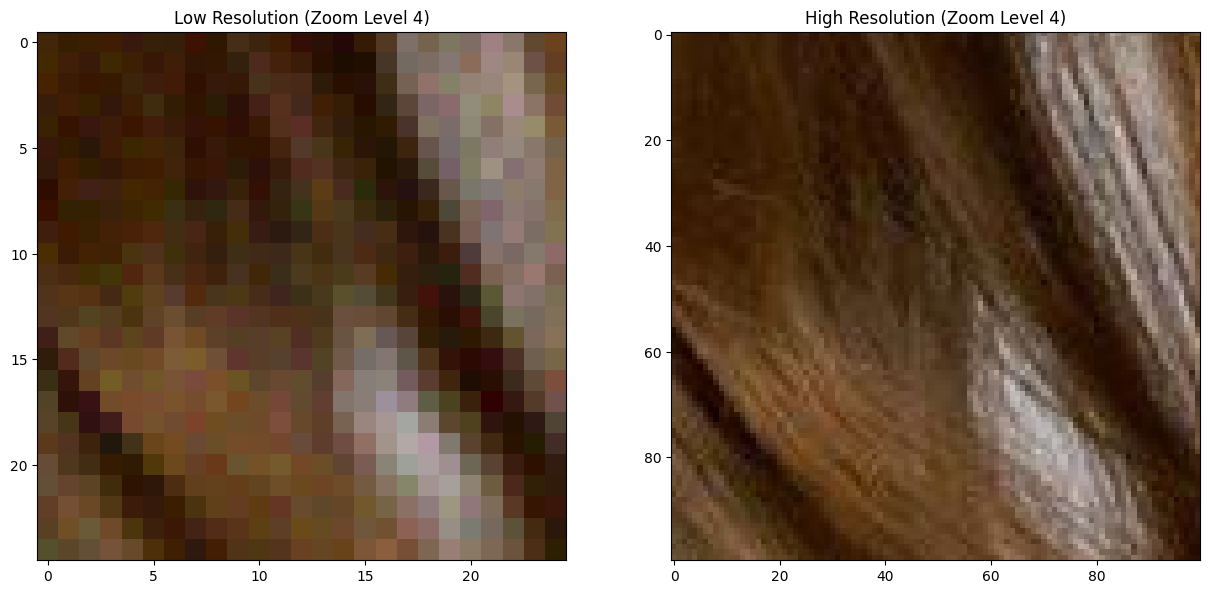

In [ ]:
# Parameters
randomize_point = True
num_zooms = 4  # Hyperparameter for number of zooms

# Zoom and display images
zoom_and_display_data(low_res, high_res, SCALE_FACTOR, num_zooms, randomize_point)

## Load Model

In [ ]:
# PaperSR
model_name = 'PaperSR~10_4_32_0.0005_BEST'
model = PaperSR(scale=SCALE_FACTOR).to(device)


# # FSRCNN
# model_name = 'FSRCNN~10_4_32_0.0005_BEST'
# model = FSRCNN(scale_factor=SCALE_FACTOR).to(device)


# # ResFSRCNN
# model_name = 'ResFSRCNN_20_4_32_0.0005_BEST'
# model = ResFSRCNN(scale_factor=SCALE_FACTOR).to(device)




In [ ]:
LEARNING_RATE = 5e-04
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
#scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.3)

## Train Model

In [ ]:
def train(model, loader, optimizer, criterion, device):
    model.train()  # Set the model to training mode
    running_loss = 0.0
    i = 0
    for low_res, high_res in loader:
        low_res, high_res = low_res.to(device), high_res.to(device)
        optimizer.zero_grad()  # Clear previous gradients
        outputs = model(low_res)  # Forward pass
        loss = criterion(outputs, high_res)  # Compute loss
        loss.backward()  # Backward pass
        optimizer.step()  # Update model parameters
        running_loss += loss.item()
        i += 1
        #if i % 200 == 0:
        #    print(i)
    return running_loss / len(loader)  # Return average loss

def validate(model, loader, criterion, device):
    model.eval()  # Set the model to evaluation mode
    running_loss = 0.0
    with torch.no_grad():  # Disable gradient computation
        for low_res, high_res in loader:
            low_res, high_res = low_res.to(device), high_res.to(device)
            outputs = model(low_res)
            loss = criterion(outputs, high_res)
            running_loss += loss.item()
    return running_loss / len(loader)  # Return average loss

def vis(plt, train_losses, val_losses):
    # Plot the current loss values
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Training and Validation Loss per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # Update the plot
    clear_output(wait=True)
    display(plt.gcf())
    plt.close()

In [ ]:
# Initialize interactive mode for plotting
plt.ion()

low_res, high_res = dataset[4]
low_res = low_res.unsqueeze(0)
bicubic = nn.functional.interpolate(low_res, scale_factor=SCALE_FACTOR, mode='bicubic', align_corners=True)[0]

# Lists to store loss values for plotting
train_losses = []
val_losses = []

# Training loop
for epoch in range(EPOCHS):
    train_loss = train(model, train_loader, optimizer, criterion, device)
    val_loss = validate(model, val_loader, criterion, device)

    # Store losses
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    # Beautified print statement with 5 decimal points
    print(f"Epoch ({epoch+1}/{EPOCHS}), Train Loss: [{train_loss:.6f}], Val Loss: [{val_loss:.6f}]")

    #vis(plt, train_losses, val_losses)


    output = model(low_res.to(device))
    up_res = output.squeeze(0).cpu().detach()
    visualize_images(bicubic[:, 250:450, 300:500], up_res[:, 250:450, 300:500], high_res[:, 250:450, 300:500])

# Disable interactive mode after training
#plt.ioff()

#15 epochs in 187 minutes


#below is a new training loop
we save on each epoch to ensure no error can jeopardize the training

In [ ]:
# Initialize interactive mode for plotting
plt.ion()

low_res, high_res = dataset[4]
low_res = low_res.unsqueeze(0)
bicubic = nn.functional.interpolate(low_res, scale_factor=SCALE_FACTOR, mode='bicubic', align_corners=True)[0]

# Lists to store loss values for plotting
train_losses = []
val_losses = []

# Define the model save path
model_name = f"{model.__class__.__name__}_{EPOCHS}_{SCALE_FACTOR}_{BATCH_SIZE}_{LEARNING_RATE}.pth"
#model_name = 'ResFSRCNN_20_4_32_0.0005.pth'
save_path = f"./models/{model_name}"

# Function to save the model state
def save_model(model, epoch, optimizer, filename):
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict()
    }, filename)

# Function to load the model state
def load_model(model, optimizer, filename):
    checkpoint = torch.load(filename)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    return checkpoint['epoch']

# Try to resume training if possible
start_epoch = 0
if os.path.exists(save_path):
    start_epoch = load_model(model, optimizer, save_path)
    print(f"Resuming training from epoch {start_epoch}")

# Training loop
for epoch in range(start_epoch, EPOCHS):
    try:
        train_loss = train(model, train_loader, optimizer, criterion, device)
        val_loss = validate(model, val_loader, criterion, device)

        # Store losses
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        #scheduler.step()
        print(f"Epoch ({epoch+1}/{EPOCHS}), Train Loss: {train_loss:.6f}, Val Loss: {val_loss:.6f}")

    except Exception as e:
        print(f"Error occurred in epoch {epoch+1}: {e}")
        # Load the last saved model to resume training
        start_epoch = load_model(model, optimizer, save_path)
        print(f"Resuming training from epoch {start_epoch}")
        continue

    # Save the model state after each epoch, or after an error
    save_model(model, epoch+1, optimizer, save_path)

    output = model(low_res.to(device))
    up_res = output.squeeze(0).cpu().detach()
    visualize_images(bicubic[:, 250:450, 300:500], up_res[:, 250:450, 300:500], high_res[:, 250:450, 300:500])

# Disable interactive mode after training
#plt.ioff()


## Save Model

In [ ]:
# Save the model
name = f"./models/{model.__class__.__name__}~{EPOCHS}_{SCALE_FACTOR}_{BATCH_SIZE}_{LEARNING_RATE}.pth"
torch.save(model.state_dict(), name)

In [ ]:
print(val_losses)

## Visualize Model

In [ ]:
randomize_idx = True  # Set to False to disable randomization
random_index = random.randint(0, len(dataset) - 1) if randomize_idx else 0
print(f"Random index: {random_index}")

low_res, high_res = dataset[random_index]
print(low_res.shape, high_res.shape)


In [ ]:
low_res = low_res.unsqueeze(0)
output = model(low_res.to(device))
up_res = output.squeeze(0).cpu().detach()

bicubic = nn.functional.interpolate(low_res, scale_factor=4, mode='bicubic', align_corners=True)[0]
print(bicubic.shape)
print(up_res.shape)
print(high_res.shape)
visualize_images(bicubic, up_res, high_res)

In [ ]:
from utils.vis import calculate_point
def zoom(low_res, up_res, high_res, scale_factor, num_zooms, randomize_point=True):
    hr_height, hr_width = high_res.shape[-2], high_res.shape[-1]

    # Calculate random or fixed point for zooming
    zoom_point_x, zoom_point_y = calculate_point((hr_height, hr_width), randomize_point)

    # Ensure zoom window maintains aspect ratio
    hr_aspect_ratio = hr_width / hr_height

    # Iterate through zoom levels
    for zoom_level in range(num_zooms):
        # Calculate zoom window size, maintaining aspect ratio


        hr_zoom_window_width = int(hr_width // (2 ** zoom_level))
        hr_zoom_window_height = int(hr_zoom_window_width / hr_aspect_ratio)



        # Calculate corresponding coordinates for high-resolution and upscaled images
        hr_end_x = min(zoom_point_x + hr_zoom_window_width, hr_width)
        hr_end_y = min(zoom_point_y + hr_zoom_window_height, hr_height)

        # Plotting the images
        plt.figure(figsize=(15, 15))

        # Low-resolution image
        plt.subplot(1, 3, 1)
        plt.title(f'Low Resolution (Zoom Level {zoom_level + 1})')
        plt.imshow(low_res.permute(1, 2, 0)[zoom_point_y:hr_end_y, zoom_point_x:hr_end_x, :])

        # Upscaled image
        plt.subplot(1, 3, 2)
        plt.title(f'Upscaled Resolution (Zoom Level {zoom_level + 1})')
        plt.imshow(up_res.permute(1, 2, 0)[zoom_point_y:hr_end_y, zoom_point_x:hr_end_x, :])

        # High-resolution image
        plt.subplot(1, 3, 3)
        plt.title(f'High Resolution (Zoom Level {zoom_level + 1})')
        plt.imshow(high_res.permute(1, 2, 0)[zoom_point_y:hr_end_y, zoom_point_x:hr_end_x, :])

        plt.show()

In [ ]:
# Parameters
randomize_point = True
num_zooms = 4  # Hyperparameter for number of zooms

# Zoom and display images
#zoom(bicubic, up_res, high_res, SCALE_FACTOR, num_zooms, randomize_point)
pointX = 400
pointY = 400
scale = 200
visualize_images(bicubic[:, pointY:pointY + scale, pointX:pointX + scale], up_res[:, pointY:pointY + scale, pointX:pointX + scale], high_res[:, pointY:pointY + scale, pointX:pointX + scale])